## Imports

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")
sns.set_style("darkgrid")

import cv2

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, AvgPool2D, Dropout, Flatten, Activation, ReLU
from keras.metrics import binary_accuracy, categorical_accuracy
from keras.utils import to_categorical

## Helpers

In [357]:
def plot_history(train_data):
    
    for data in train_data:
        history = data[0].history
        title = data[1]
        
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        fig.suptitle(title, fontsize=16, y=1.05)
        ax[0].plot(history['accuracy'])
        ax[0].plot(history['val_accuracy'])
        ax[0].legend(['train', 'val'])
        ax[0].set(title=f"train acc : {history['accuracy'][-1]}\nval acc : {history['val_accuracy'][-1]}", 
                  xlabel='epoch', ylabel='accuracy')

        ax[1].plot(history['loss'])
        ax[1].plot(history['val_loss'])
        ax[1].legend(['train', 'val'])
        ax[1].set(title=f"train loss : {history['loss'][-1]}\nval loss : {history['val_loss'][-1]}", 
                  xlabel='epoch', ylabel='loss')
        plt.show()

## Load dataset

In [364]:
labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
data = pd.read_csv('data/FER2013/fer2013.csv')
X = []
for index, row in data.iterrows():
    image_pixels = np.asarray(list(row['pixels'].split(' ')), dtype=np.float64)
    image_pixels = image_pixels.reshape((48,48))
    X.append(image_pixels)
X = np.array(X)
X = np.expand_dims(X, 3)

y = to_categorical(data['emotion'].values)

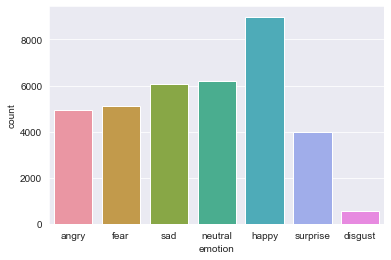

In [368]:
sns.countplot(data['emotion'].apply(lambda x : labels.get(x)))
plt.show()

From the above countplot graphic we can check that: 
- we have way more __*happy*__ samples than the rest of the other ones. 
- __*disgust*__ samples are almost 7 times less if compared to the category with more samples, __*happy*__.
- it is necessary to keep an eye on this imbalance on categories, once it may lead our model to bias towards happy labels and miss a lot of disgust samples.

## Models

####  Lenet

In [379]:
def build_lenet5():
    model = Sequential(name='LeNet-5')
    # Layer C1 (convolution) - 6 feature maps 28x28
    model.add(Conv2D(6, (5,5), strides=(1,1), input_shape=(48,48,1), name='C1', activation='relu'))
    
    # Layer S2 (sub-sampling) - 6 feature maps 14x14
    model.add(AvgPool2D(pool_size=(2,2), name='S2'))
    
    # Layer C3 (convolution) - 16 feature maps 10x10
    model.add(Conv2D(16, (5,5), strides=(1,1), name='C3', activation='relu'))
    
    # Layer S4 (sub-samlping) - 16 feature maps 5x5
    model.add(AvgPool2D(pool_size=(2,2), name='S4'))
    
    # Layer C5 (convolution) - 16 feature maps 10x10 - Flattened layer
    model.add(Conv2D(120, (4,4), strides=(1,1), name='C5', activation='relu'))
    model.add(Flatten(name='C5-Flat'))
    model.add(Dense(120, name='C5-Dense', activation='relu'))
    
    # Layer F6 - Full connection 84
    model.add(Dense(84, name='F6'))
    
    # Output layer
    model.add(Dense(7, activation='softmax', name='Output'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

#### Custom Model 1

In [380]:
def build_custom1():
    model = Sequential(name='LeNet-5')

    model.add(Conv2D(64, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(256, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(7, activation='softmax', name='Output'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

## Models tests

In [362]:
test_history = []

#### Test 1

- Model 1
- no pixel modification
- train/test ration = 0.8

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = build_lenet5()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=2)
test_history.append((history, 'Model 1 - vanilla'))

Train on 28709 samples, validate on 7178 samples
Epoch 1/15
 - 26s - loss: 2.0374 - accuracy: 0.3352 - val_loss: 1.5705 - val_accuracy: 0.3866
Epoch 2/15
 - 27s - loss: 1.5534 - accuracy: 0.3943 - val_loss: 1.5218 - val_accuracy: 0.4078
Epoch 3/15
 - 27s - loss: 1.4782 - accuracy: 0.4290 - val_loss: 1.4881 - val_accuracy: 0.4177
Epoch 4/15
 - 27s - loss: 1.3994 - accuracy: 0.4625 - val_loss: 1.4942 - val_accuracy: 0.4248
Epoch 5/15
 - 27s - loss: 1.3250 - accuracy: 0.4919 - val_loss: 1.4166 - val_accuracy: 0.4624
Epoch 6/15
 - 26s - loss: 1.2492 - accuracy: 0.5276 - val_loss: 1.3929 - val_accuracy: 0.4667
Epoch 7/15
 - 26s - loss: 1.1564 - accuracy: 0.5633 - val_loss: 1.4376 - val_accuracy: 0.4713
Epoch 8/15
 - 25s - loss: 1.0557 - accuracy: 0.6040 - val_loss: 1.4725 - val_accuracy: 0.4700
Epoch 9/15
 - 26s - loss: 0.9514 - accuracy: 0.6464 - val_loss: 1.5719 - val_accuracy: 0.4677
Epoch 10/15
 - 26s - loss: 0.8377 - accuracy: 0.6931 - val_loss: 1.7794 - val_accuracy: 0.4720
Epoch 11/1

#### Test 2

- Model 1
- pixel normalization : mean
- train/test ration = 0.8

In [375]:
mean = np.mean(X)
X_mean = X - mean
X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)
model = build_lenet5()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=2)
test_history.append((history, 'Model 1 - pixel normalization (only mean pixel value)'))

Train on 28709 samples, validate on 7178 samples
Epoch 1/15
 - 26s - loss: 1.5652 - accuracy: 0.3918 - val_loss: 1.4275 - val_accuracy: 0.4522
Epoch 2/15
 - 27s - loss: 1.3342 - accuracy: 0.4942 - val_loss: 1.3271 - val_accuracy: 0.4882
Epoch 3/15
 - 26s - loss: 1.2075 - accuracy: 0.5426 - val_loss: 1.3094 - val_accuracy: 0.5032
Epoch 4/15
 - 26s - loss: 1.0576 - accuracy: 0.5940 - val_loss: 1.3478 - val_accuracy: 0.4987
Epoch 5/15
 - 26s - loss: 0.8821 - accuracy: 0.6721 - val_loss: 1.4555 - val_accuracy: 0.5163
Epoch 6/15
 - 26s - loss: 0.7128 - accuracy: 0.7383 - val_loss: 1.6141 - val_accuracy: 0.5171
Epoch 7/15
 - 26s - loss: 0.5559 - accuracy: 0.8004 - val_loss: 1.8422 - val_accuracy: 0.4850
Epoch 8/15
 - 26s - loss: 0.4652 - accuracy: 0.8348 - val_loss: 2.0426 - val_accuracy: 0.5070
Epoch 9/15
 - 26s - loss: 0.3766 - accuracy: 0.8669 - val_loss: 2.2589 - val_accuracy: 0.5028
Epoch 10/15
 - 26s - loss: 0.3292 - accuracy: 0.8859 - val_loss: 2.4187 - val_accuracy: 0.4999
Epoch 11/1

#### Test 3

- Model 1
- pixel normalization : mean + std
- train/test ration = 0.8

In [376]:
mean = np.mean(X)
std = np.std(X)
X_mean_std = (X - mean)/std
X_train, X_test, y_train, y_test = train_test_split(X_mean_std, y, test_size=0.2, random_state=42)
model = build_lenet5()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=2)
test_history.append((history, 'Model 1 - pixel normalization (mean + std pixel value)'))

Train on 28709 samples, validate on 7178 samples
Epoch 1/15
 - 26s - loss: 1.5530 - accuracy: 0.3921 - val_loss: 1.4253 - val_accuracy: 0.4393
Epoch 2/15
 - 27s - loss: 1.3322 - accuracy: 0.4846 - val_loss: 1.2894 - val_accuracy: 0.5032
Epoch 3/15
 - 26s - loss: 1.1920 - accuracy: 0.5438 - val_loss: 1.2626 - val_accuracy: 0.5160
Epoch 4/15
 - 26s - loss: 1.0522 - accuracy: 0.6020 - val_loss: 1.2363 - val_accuracy: 0.5332
Epoch 5/15
 - 26s - loss: 0.9050 - accuracy: 0.6617 - val_loss: 1.2896 - val_accuracy: 0.5426
Epoch 6/15
 - 26s - loss: 0.7398 - accuracy: 0.7253 - val_loss: 1.4057 - val_accuracy: 0.5346
Epoch 7/15
 - 26s - loss: 0.5768 - accuracy: 0.7887 - val_loss: 1.6352 - val_accuracy: 0.5415
Epoch 8/15
 - 26s - loss: 0.4427 - accuracy: 0.8412 - val_loss: 1.8325 - val_accuracy: 0.5280
Epoch 9/15
 - 26s - loss: 0.3333 - accuracy: 0.8816 - val_loss: 2.3283 - val_accuracy: 0.5249
Epoch 10/15
 - 26s - loss: 0.2755 - accuracy: 0.9052 - val_loss: 2.4448 - val_accuracy: 0.5223
Epoch 11/1

#### Test 4

- Model Custom 1
- pixel normalization : mean + std
- train/test ration = 0.8

In [ ]:
mean = np.mean(X)
std = np.std(X)
X_mean_std = (X - mean)/std
X_train, X_test, y_train, y_test = train_test_split(X_mean_std, y, test_size=0.2, random_state=42)
model = build_custom1()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=1)
test_history.append((history, 'Model 1 - pixel normalization (mean + std pixel value)'))

## Results visualisation

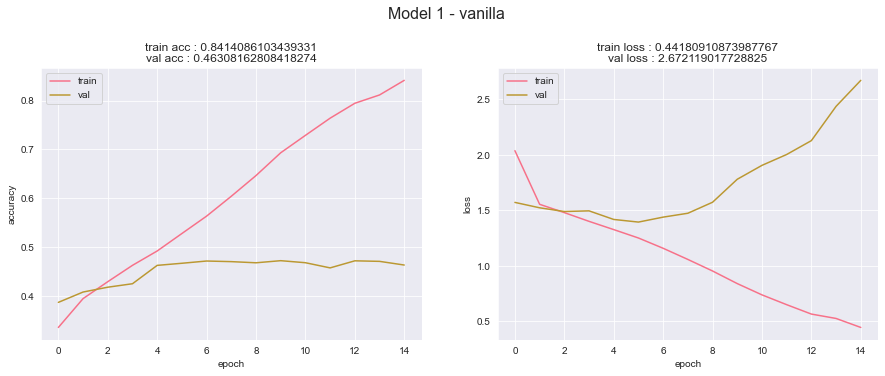

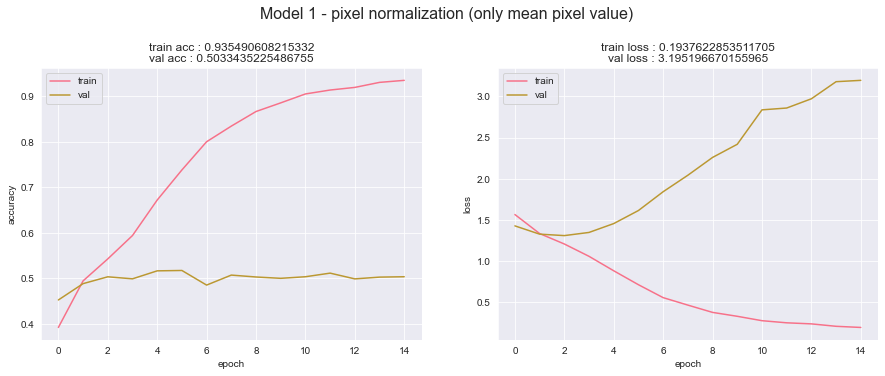

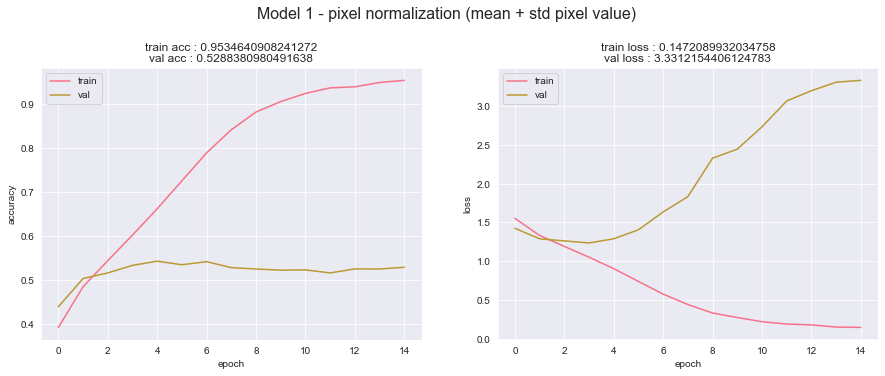

In [378]:
plot_history(test_history)

In [308]:
# labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
img = cv2.imread('dummy7.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, dsize=(48,48), interpolation=cv2.INTER_CUBIC)
img = np.expand_dims(img,[0,3])

In [309]:
img.shape

(1, 48, 48, 1)

In [313]:
labels.get(np.argmax(model4.predict(img)))

'angry'